# Week 5-6, Data science in Neuroscience


## Plan for this week

1. Introduction to pytorch
2. Tensors
3. Training loop in pytorch
4. A first neural network
5. Convolutional networks to process images

***


# Convolutional neural networks (CNN)

Date back to 1989 (Yann LeCun). 

Convolutional neural network revolutionized how images are processed by neural network. 

They are used for all sorts of problems involving image processing.

The artificial neurons in the network have receptive fields, similar to what is observed in the visual system.

Why they work:

* They keep information about the spatial arrangement of the input image.
* Mechanism to detect a set a feature, independently of their position in the image. 

## Convolution 

<div>
<img src="../images/convolution1.png" width="800"/>
</div>

## LeNet: one of the first convolutional neural network.

LeCun et al. (1989). Backpropagation applied to handwritten zip code recognition. Neural Computation.


<div>
<img src="../images/LeNet5.png" width="1200"/>
</div>




## Convolutional Neural Networks as feature detectors


<div>
<img src="../images/imageNet_features_01.png" width="300"/>
</div>


<div>
<img src="../images/imageNet_features_02.png" width="600"/>
</div>



<div>
<img src="../images/imageNet_features_03.png" width="600"/>
</div>

<div>
<img src="../images/imageNet_features_04.png" width="600"/>
</div>



## ImageNet competition: 1.3 million images and 1000 classes

<div>
<img src="../images/imageNetResults.png" width="800"/>
</div>



# Let's build and train a convolutional neural network

Our aim will be to build a convolutional neural network to identify what object is in images. This is a classification problem.



## Dataset

We need a dataset of imagest to train our model.

We download our dataset using torchvision.datasets. We will use the CIFAR-10 dataset. It consists of 60000 small 32x32 color images.

https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html


In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [22]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [24]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [25]:
img,label = train_dataset[99]

In [26]:
img.shape

torch.Size([3, 32, 32])

The shape is [Color, Height, Width].

The first dimension of size 3 represent the color channels.

In [27]:
label

1

The labels are just numbers. We can associate a word to these numbers by creating a list of labels.

In [28]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [29]:
class_names[label]

'car'

Plot a few images and labels from our dataset.

In [30]:
img.squeeze().shape

torch.Size([3, 32, 32])

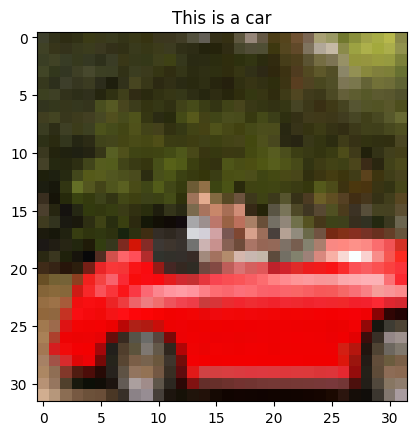

In [31]:
plt.imshow(img.permute(1,2,0)) # we use permute because imshow() wants [Height,Width,Color] and the tensor is [Color,Height,Width].
plt.title("This is a {}".format(class_names[label]))
plt.show()

## Exercise

Create a figure with several subplots. In each subplot, show the image with imshow() and put the label as title.

## Transforms and normalization

Images are usually stored as integers with values ranging from 0 to 255.

Neural network works best when your data that are close to 0.

To make sure our input data facilitate learning:  
* Normalize so that the mean = 0 and a standard deviation = 1
* All features or color channels have the same distribution 

Making sure that the different features have the same distribution means that the choosen learning rate will be appropriate for all features. 

When we use the `torchvision.transforms.ToTensor()` in our dataset, the range of the data is automatically transformed from a range of 0 to 255 to a range of 0 to 1.

In [32]:
img.min(), img.max()

(tensor(0.), tensor(1.))

We can improve this further by making sure our different features (color channels) have a similar distribution with a mean of 0.

In [33]:
a = torch.stack([img for img,_ in train_dataset],dim=3)
a.shape

torch.Size([3, 32, 32, 50000])

In [34]:
a.view(3,-1).mean(1),a.view(3,-1).std(1)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [35]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.4915,0.4823,0.4468), # means of each color channel
                                                                            (0.2470,0.2435,0.2616))]) # standard deviation of each color channel

# We pass the transform function to the dataset
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)




Files already downloaded and verified
Files already downloaded and verified


In [36]:
a = torch.stack([img for img,_ in test_dataset],dim=3)
print(a.shape)

torch.Size([3, 32, 32, 10000])


Text(0, 0.5, 'Number of pixels')

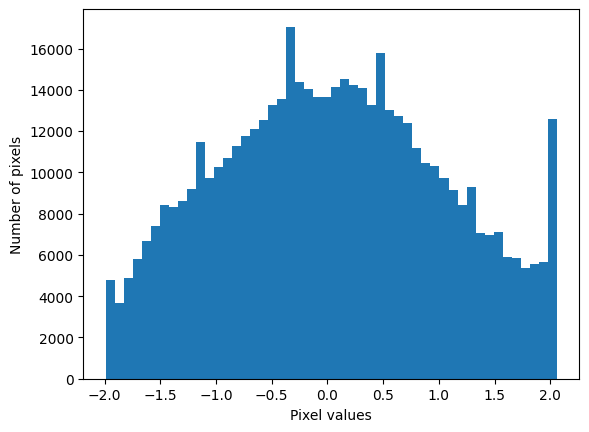

In [37]:
plt.hist(a[0,:,:,0:500].flatten(),bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Number of pixels")

In [17]:
#a = torch.stack([img for img,_ in train_dataset],dim=3)
#a.shape
#a.view(3,-1).mean(1),a.view(3,-1).std(1)

In [38]:
img,label = train_dataset[99]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


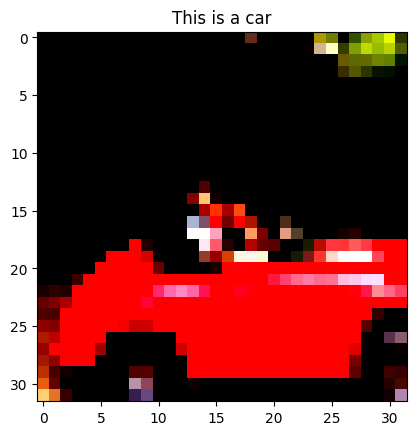

In [39]:
plt.imshow(img.permute(1,2,0)) # we use permute because imshow() wants H x W x C and the tensor is C X H X W.
plt.title("This is a {}".format(class_names[label]))
plt.show()

## Dataloader

We usually want to feed a few images at a time to our neural network. With large models and datasets, we would not be able to fit all that data in the GPU or computer memory. So we feed a few items at a time. 

The small group of images that we are feeding to the network simultaneously is called a `batch`.

The number of images that we feed to the neural network simultaneously is called the `batch size`.

pytorch has a `dataloader` class that can help you getting 

In [40]:
batch_size=16

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=2, 
                                           pin_memory=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=2)

In [50]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [51]:
images.shape

torch.Size([16, 3, 32, 32])

The shape is [Batch, Color, Height, Width].

In [52]:
labels.shape

torch.Size([16])

## Our model

We can build our model using the class from the last class.

<div>
<img src="../images/LeNet5.png" width="1200"/>
</div>



* Convolution: `torch.nn.Conv2d`
* Subsampling: `torch.nn.MaxPool2d`
* Full connection: `torch.nn.Linear` 

In [64]:
class Convolutional_model(nn.Module):
    """
    Class to create convolutional neural network.
    """
    def __init__(self):
        """
        Initializer. Runs when an object is created
        """
        super().__init__()
        
        # input images will be batch_size,3,32,32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size=5,stride=1, padding=0)  # output shape: [batch_size, 6, 28, 28]
        self.pool1 = nn.MaxPool2d(kernel_size=2) # a max poll operation, # output shape: [batch_size, 6, 14,14]
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1, padding=0)  # output shape: [batch_size, 16, 10, 10]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                                   # output shape: [batch_size, 16 , 5, 5]
        
        
        self.fc1 = nn.Linear(in_features = 16 * 5 * 5, out_features=120) # here we need to know the dimension of the data coming in (following second pool operation)
        self.fc2 = nn.Linear(in_features = 120, out_features =84)
        self.fc3 = nn.Linear(in_features = 84, out_features=10)
        
    def forward(self,x):
        """
        Make predictions with our model
        """

        # We have 2 x pool(relu(conv()))
        # This is the part extracting visual features
        
        # input shape [batch,3,32,32]
        x = F.relu(self.conv1(x)) # [batch, 6, 28, 28]
        x = self.pool1(x) # [batch, 6, 14, 14]
        
        x = F.relu(self.conv2(x)) # [batch, 16, 10, 10]
        x = self.pool2(x) # [batch, 16, 5, 5]

        # We then have 3 linear layers. These layers are take visual features as inputs and find a way to classify the image.
        x = torch.flatten(x, 1) # flatten all dimensions except batch, needed for the linear layer, [batch, 400]
        x = F.relu(self.fc1(x)) # [batch, 120]
        x = F.relu(self.fc2(x)) # [batch, 84]
        x = self.fc3(x) # [batch, 10]
        return x


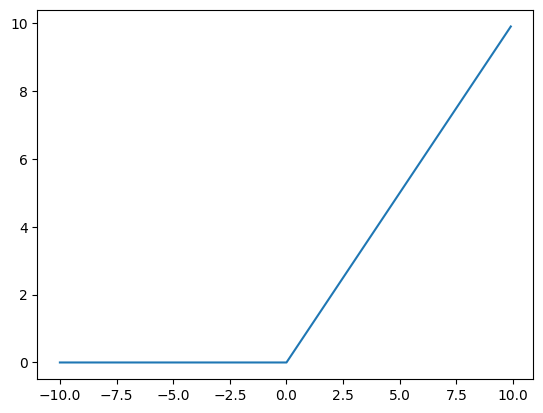

In [122]:
plt.plot(torch.arange(-10,10,0.1), F.relu(torch.arange(-10,10,0.1)))

### When creating/modifying models, add one layer at a time**

Below we just recreate the 4 layers of our model so that we can experiment with them.

In [57]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [58]:
conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1,padding=0)

In [59]:
images.shape

torch.Size([16, 3, 32, 32])

In [61]:
out = conv1(images)

In [62]:
out.shape

torch.Size([16, 6, 28, 28])

In [63]:
pool1 = nn.MaxPool2d(kernel_size=2)
out = pool1(out)
out.shape

torch.Size([16, 6, 14, 14])

In [ ]:
conv2 = nn.Conv2d(in_channels=6,out_channels=16, kernel_size=5, stride=1, padding=0)
pool2 = nn.MaxPool2d(kernel_size=2)

We can pass our batch of images in each layer and print the output size for example.

In [26]:
print("images.shape:",images.shape)
res = F.relu(conv1(images))
print("output of conv1 shape:", res.shape)
res = pool1(res)
print("output of pool shape:", res.shape)
res = F.relu(conv2(res))
print("output of conv2 shape:", res.shape)
res = pool2(res)
print("output of pool shape:", res.shape)

images.shape: torch.Size([16, 3, 32, 32])
output of conv1 shape: torch.Size([16, 6, 28, 28])
output of pool shape: torch.Size([16, 6, 14, 14])
output of conv2 shape: torch.Size([16, 16, 10, 10])
output of pool shape: torch.Size([16, 16, 5, 5])


In [65]:
conv_model = Convolutional_model()

In [68]:
conv_model

Convolutional_model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [66]:
#for name,p in conv_model.named_parameters():
#    print(name,p.shape,p)

In [67]:
print("Number of parameters:", sum(p.numel() for p in conv_model.parameters()))

Number of parameters: 62006


Is this large?

* A linear regression model: 2 parameters
* Chat-GPT4: 1.76 trillion parameters

To today's standards, this is a very small convolution neural network.

In [71]:
conv_model(images)[0]

tensor([-0.0619,  0.1438,  0.0849, -0.0803,  0.0806,  0.1164, -0.0447,  0.1181,
        -0.0279, -0.0199], grad_fn=<SelectBackward0>)

In [72]:
class_names

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [73]:
labels

tensor([8, 6, 4, 9, 4, 8, 2, 1, 2, 5, 4, 9, 7, 9, 5, 6])

## Loss function

We need a loss function that works with categorical data. 

The idea is that we have as many output numbers as there are categories. These numbers are the probability that the image is part of a category.

For instance, if the label of an image is `car` (value 1), the ideal output of the network would be `0100000000`. 

The last layer has an output size of 10, which is the number of categories we have in the dataset.

In [75]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

More information about the cross entropy loss function:  https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 

## Training the model

In [76]:
def training_loop(n_epochs, optimizer, loss_fn, model, train_dataloader):
    for epoch in range (n_epochs):
        
        loss_sum = 0.0
        for batch_no, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images, labels = data
        
        
            yhat = model(images) # make predictions
            loss = loss_fn(yhat,labels) # calculate the loss
            
            optimizer.zero_grad() # zero the gradients of our model's parameters
            loss.backward() # calculate gradients of the model's parameters
            optimizer.step() # will change the model parameters to reduce the loss
        
            loss_sum = loss_sum + loss.item()
            
            if batch_no % 500 == 499:
                print("Epoch: {}, batch: {} Loss: {}".format(epoch,batch_no+1, loss_sum))
                loss_sum=0.0
    return

In [78]:
training_loop(n_epochs=3,
              optimizer=optimizer,
              loss_fn=loss_fn,
              model=conv_model,
             train_dataloader=train_dataloader)

Epoch: 0, batch: 500 Loss: 620.0342646241188
Epoch: 0, batch: 1000 Loss: 618.8805445432663
Epoch: 0, batch: 1500 Loss: 619.5650469064713
Epoch: 0, batch: 2000 Loss: 609.3703420758247
Epoch: 0, batch: 2500 Loss: 610.5137358307838
Epoch: 0, batch: 3000 Loss: 616.5101228356361
Epoch: 1, batch: 500 Loss: 580.9940719008446
Epoch: 1, batch: 1000 Loss: 588.9493147730827
Epoch: 1, batch: 1500 Loss: 575.4773086905479
Epoch: 1, batch: 2000 Loss: 581.4485549628735
Epoch: 1, batch: 2500 Loss: 585.1773946285248
Epoch: 1, batch: 3000 Loss: 578.0868128538132
Epoch: 2, batch: 500 Loss: 551.8107440471649
Epoch: 2, batch: 1000 Loss: 548.4174157381058
Epoch: 2, batch: 1500 Loss: 551.0435487031937
Epoch: 2, batch: 2000 Loss: 557.2260854840279
Epoch: 2, batch: 2500 Loss: 559.431689620018
Epoch: 2, batch: 3000 Loss: 556.2282591760159


## Saving your model to file 

With larger models trained on large datasets, you will want to save your trained model so that you don't have to train it from scratch all the time.

In [79]:
file_name = '../models/cifar10_conv_model.pth'
torch.save(conv_model.state_dict(), file_name)

## Loading your model from file

In [80]:
file_name = '../models/cifar10_conv_model.pth'
loaded_state_dict = torch.load(file_name)

In [81]:
conv_model = Convolutional_model()
conv_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

## Evaluate our trained model

In [82]:
dataiter = iter(test_dataloader)

In [91]:
class_names

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [97]:
images, labels = next(dataiter)
labels

tensor([4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9])

In [98]:
with torch.no_grad():
    res = conv_model(images)

We can use the `torch.max()` function to get the index with the highest value.

In [105]:
res.shape

torch.Size([16, 10])

In [99]:
_, predictions = torch.max(res,1)

In [100]:
predictions

tensor([4, 3, 9, 9, 4, 9, 9, 5, 0, 6, 7, 6, 0, 9, 3, 9])

In [101]:
labels

tensor([4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


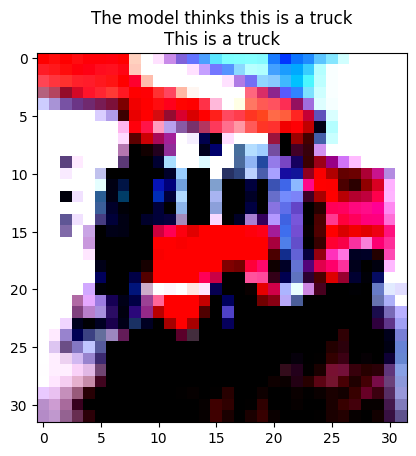

In [104]:
index = 6
plt.imshow(images[index].permute(1,2,0))
plt.title("The model thinks this is a {}\nThis is a {}".format(class_names[predictions[index].item()],
                                                          class_names[labels[index]]))
plt.show()

In [106]:
labels == predictions

tensor([ True, False,  True, False,  True, False,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True])

In [107]:
torch.sum(labels == predictions)

tensor(11)

In [108]:
torch.sum(labels==predictions)/predictions.shape[0]

tensor(0.6875)

In [109]:
def evaluate_model_accuracy(model, dataloader):
    """
    Function to calculate the classification accuracy of a model on a given dataset.
    """
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct*100/total, correct,total

In [110]:
train_accuracy,_,_ = evaluate_model_accuracy(conv_model,train_dataloader)
test_accuracy,_,_  = evaluate_model_accuracy(conv_model,test_dataloader)

In [111]:
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)

Accuracy on training set: 63.47
Accuracy on test set: 59.63


In [112]:
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = conv_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 73.4 %
Accuracy for class: car   is 79.2 %
Accuracy for class: bird  is 41.1 %
Accuracy for class: cat   is 43.6 %
Accuracy for class: deer  is 59.1 %
Accuracy for class: dog   is 37.6 %
Accuracy for class: frog  is 64.1 %
Accuracy for class: horse is 67.0 %
Accuracy for class: ship  is 61.8 %
Accuracy for class: truck is 69.4 %


You now have a better understanding of how Google, Facebook, etc. classify your images.

## Let's have a look at the filter in our first layer

In [113]:
myIter = iter(conv_model.named_parameters())
name, param = next(myIter)

In [114]:
name, param.shape

('conv1.weight', torch.Size([6, 3, 5, 5]))

In [115]:
pmin = param.min().detach().numpy().item()
pmax = param.max().detach().numpy().item()
pmin,pmax

(-0.49702975153923035, 0.5049564838409424)

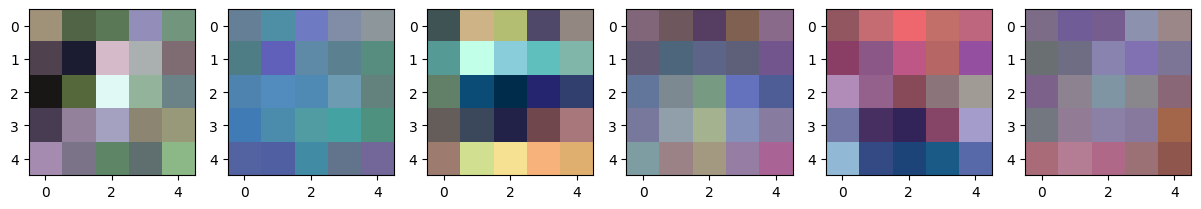

In [116]:
nrow=1
ncol=param.shape[0]
fig, ax = plt.subplots(nrow,ncol,figsize=(15,3))
for i in range(param.shape[0]):
    f = filter0 = param[i].permute(1,2,0).detach().numpy()
    f = (f-pmin)/(pmax-pmin)
    ax[i].imshow(f)
    

## Training networks using a GPU

In this notebook, we trained a very small convolutional neural network on a set of very small images. You can train these models with the CPU and it is almost as fast as using a GPU.

In most applications, you would be working with a larger convolutional network (e.g., [ResNet](https://pytorch.org/vision/main/models/resnet.html)) with images that are often more than 28x28 pixels (e.g., [ImageNet](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageNet.html)).

For such task, training is often more than 10x faster using a GPU instead of a CPU.


In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


You need to make two changes to run your model on a GPU (if you have one)

* Send the model to the GPU
* In your training loop, move your labels and images to the GPU before passing them to your model
* To work with the model output using the CPU, move the output of the model to the CPU.

In [56]:
conv_model = Convolutional_model().to(device)
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

In [57]:
def training_loop(n_epochs, optimizer, loss_fn, model, train_dataloader, test_dataloader,device):
    for epoch in range (n_epochs):
        
        loss_sum = 0.0
        for batch_no, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            data, labels = data
            data = data.to(device)
            labels = labels.to(device)
        
            yhat = model(data) # make predictions
            loss = loss_fn(yhat,labels) # calculate the loss
            
            optimizer.zero_grad() # zero the gradients of our model's parameters
            loss.backward() # calculate gradients of the model's parameters
            optimizer.step() # will change the model parameters to reduce the loss
        
            loss_sum = loss_sum + loss.item()
            
            if batch_no % 2000 == 1999:
                print("Epoch: {}, batch: {} Loss: {}".format(epoch,batch_no+1, loss_sum/2000))
                loss_sum=0.0
    return

In [58]:
%%time
training_loop(n_epochs=1,
              optimizer=optimizer,
              loss_fn=loss_fn,
              model=conv_model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             device=device)

Epoch: 0, batch: 2000 Loss: 2.047513883650303
CPU times: user 1min 51s, sys: 1.01 s, total: 1min 52s
Wall time: 11.4 s


If you load the train parameters from file, indicates on which device the parameters should be loaded.

In [59]:
file_name = '../models/cifar10_conv_model.pth'
loaded_state_dict = torch.load(file_name,map_location=device) # <- indicates whether the data should go to the GPU or CPU memory.

In [60]:
conv_model = Convolutional_model()
conv_model.load_state_dict(loaded_state_dict)
conv_model = conv_model.to(device)

We would also need to modify our function that calculate the model accuracy.

In [61]:
def evaluate_model_accuracy(model, dataloader,device):
    """
    Function to calculate the classification accuracy of a model on a given dataset.
    """
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct*100/total, correct,total

In [62]:
train_accuracy,_,_ = evaluate_model_accuracy(conv_model,train_dataloader,device)
test_accuracy,_,_  = evaluate_model_accuracy(conv_model,test_dataloader,device)

In [63]:
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)

Accuracy on training set: 53.36
Accuracy on test set: 51.46


## Exercises

Modifying your convolutional neural network to improve classification accuracy on the test dataset. For example, by adding more convolutional filters? Try to get the highest accuracy on the test dataset.

Train a convolutional neural network to classifiy images of the MNIST dataset. In MNIST, the images have only one color channel instead of 3. They have a shape of (1,28,28).